In [1]:
#challenge 2
#The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.

In [44]:
import gwpy
from gwpy.timeseries import TimeSeries

#load the data into memory
filename = "challenge2.gwf"
channel = "H1:CHALLENGE2"
data = TimeSeries.read(filename, channel)
sampling_rate = data.sample_rate.value
duration = data.duration.value
print(f"Sampling Rate: {sampling_rate}")
print(f"Duration: {duration}")


import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal



Sampling Rate: 4096.0
Duration: 128.0


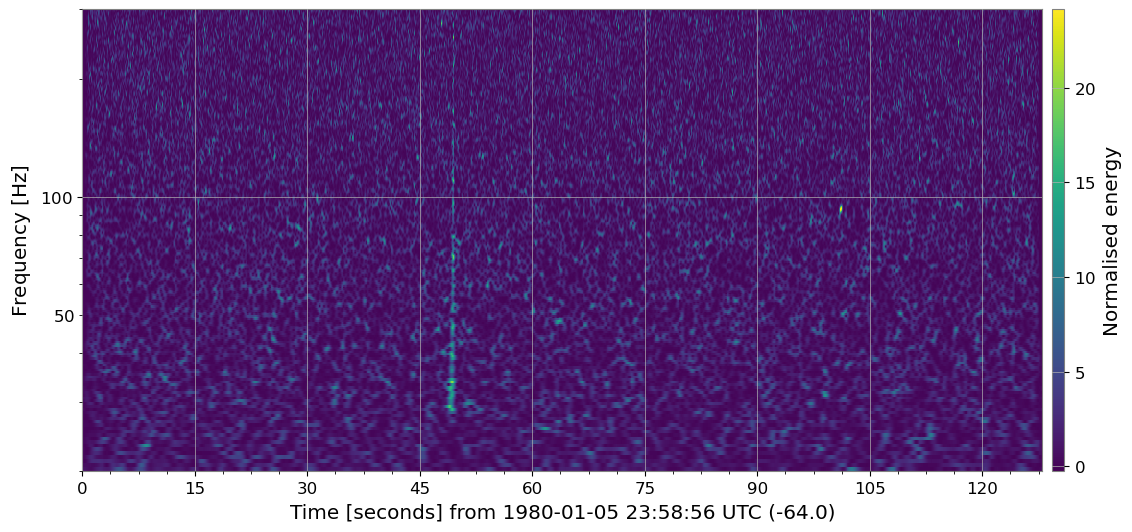

In [45]:
#q plot
q = data.q_transform(frange=(20, 300), qrange=(100, 110))
plot = q.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

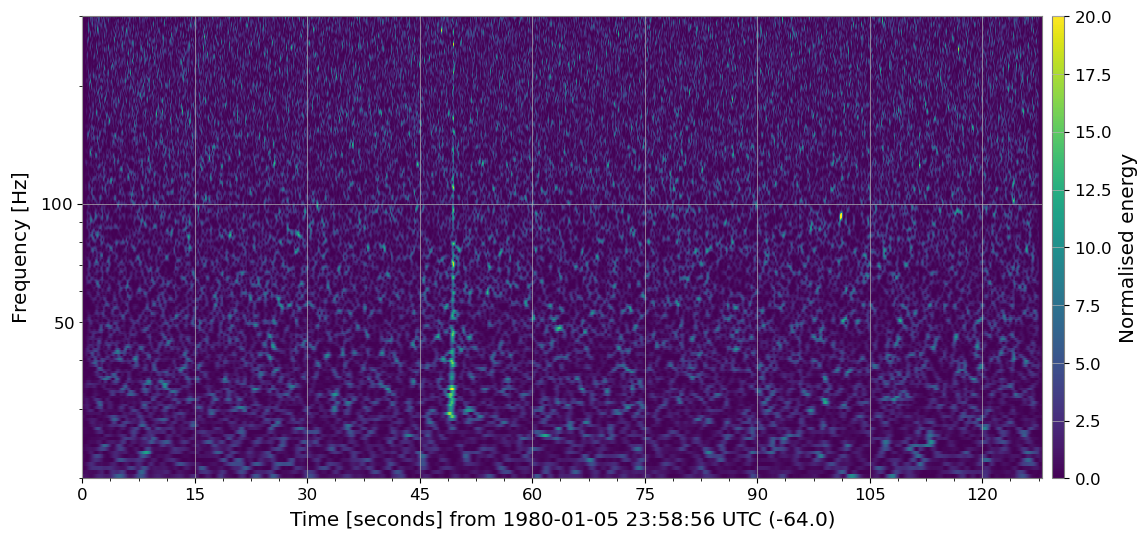

In [9]:
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
plot

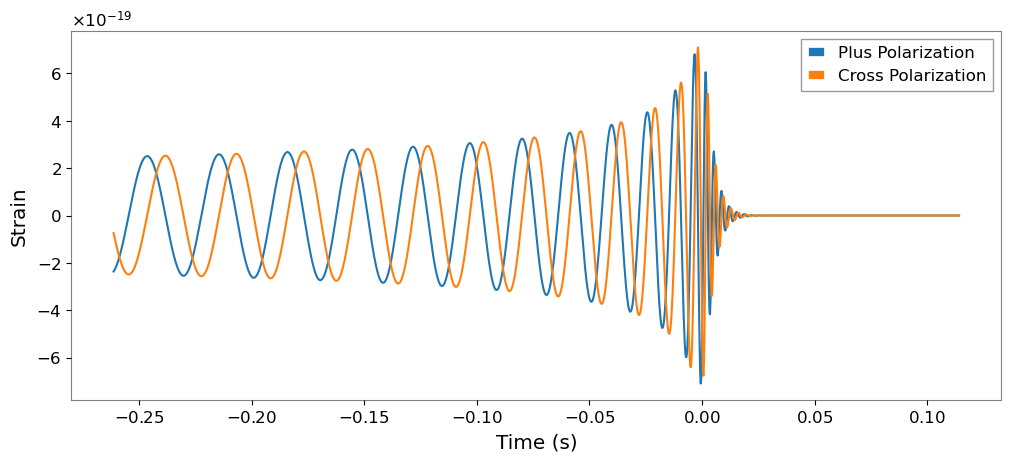

In [46]:
%matplotlib inline
#creating waveform
from pycbc.waveform import get_td_waveform
import pylab
#Wave-form
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/sampling_rate,
                         f_lower=30)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()


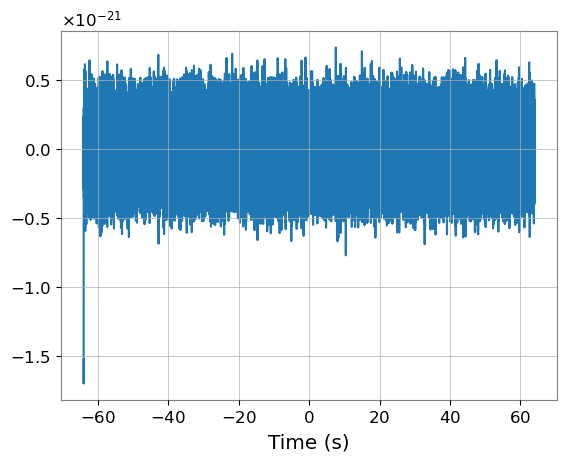

In [62]:
%matplotlib inline

import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc import frame
strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

#removing the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()


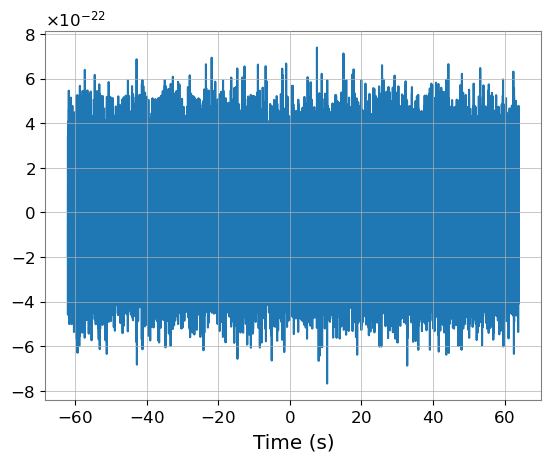

In [64]:
#remove data from end and begging to get rid of noise
conditioned = strain.crop(2, 0)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [72]:
from pycbc.psd import interpolate, inverse_spectrum_truncation

#welch method
psd = conditioned.psd(4)

#interpolate to math data and then limit the filter length of 1 / PSD
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)
print(psd)

[7.82364003e-41 7.86527676e-41 7.99116959e-41 ... 2.20057760e-48
 2.19468994e-48 2.19272936e-48]


In [71]:
from pycbc.waveform import get_td_waveform

m = 36 #solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

#resizing vector to match data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

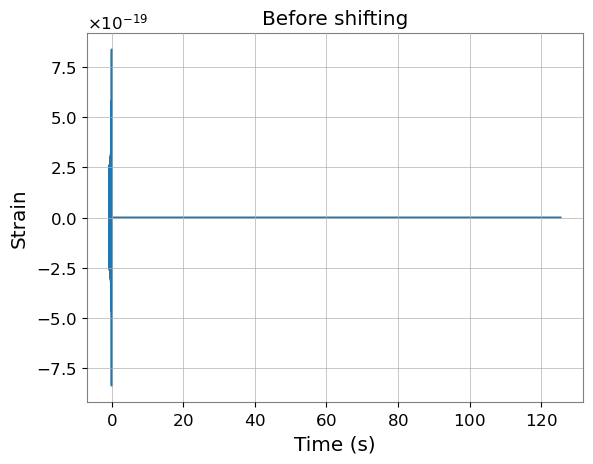

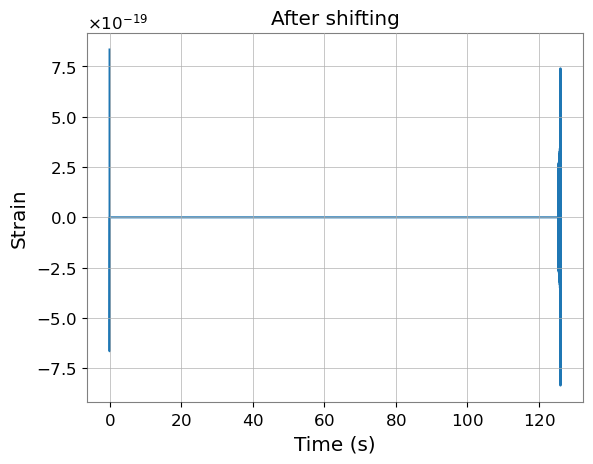

In [73]:
#signal plot before and after shift
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

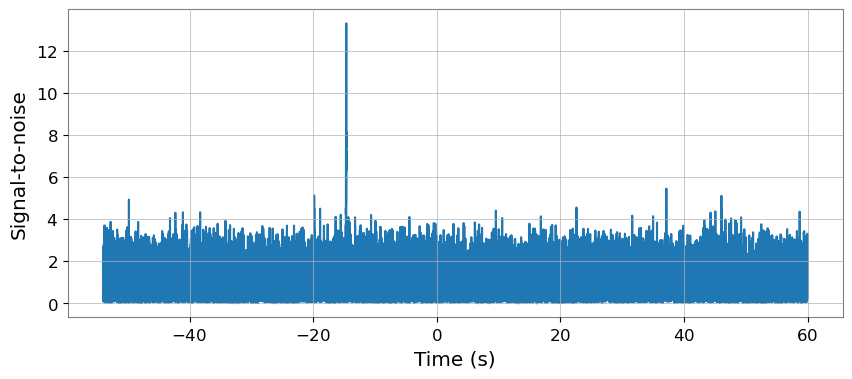

We found a signal at -14.6357421875s with SNR 13.300478647022013


In [74]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

#remove time corruption by the template and psd filter
#removing 8 seonds from the beginning and 4s seconds from end end
#the 4 exrta seconds are to account for the template length (
snr = snr.crop(4 + 4, 4)

#plotting
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))